In [1]:
#loading the library
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [5]:
#read data from web
players_data <- read_csv("https://raw.githubusercontent.com/thaviship/individual-planning-dsci-100/refs/heads/main/players.csv", 
                         col_names=TRUE)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Questions chosen

**Broad question chosen**: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

**Specific question chosen**: Which player characteristics (experience, subscribe, gender, age) are associated with higher gameplay hours among players who contribute at least some data?


## Data Description

The dataset contains 196 observations and 6 variables describing player demographics and gameplay activity. 

|Variable Name | Type | Description |
|--------------| -----| ------------|
|experience | categorical (factor) | Player's experience level|
|subscribe | categorical (logical) | Whether or not the player has a game subscription (subscribed= TRUE)|
|hashedEmail | String | A hashed version of the player's email address. Not useful for modelling|
|played_hours | numeric (continuous) | Total hours the player spent playing the game. This is the **response variable**|
|name| String/Categorical | Player's chosen name on game server. Not useful for modelling|
|gender| Categorical (factor) | Self reported gender category of the players |
|age| Numeric (integer) | Player's age in years|

### Potential Issues in Dataset

Several issues occur in the data, including duplicate entries, inconsistent gender labeling, missing values in the age column, and unnecessary identifier variables such as hashedEmail and name. 

A large portion of the dataset also consists of players with zero recorded gameplay hours, who contribute no usable data for behavioral modeling. Since the goal of this project is specifically to identify which groups contribute more gameplay data—not simply who logs in—the analysis focuses on players who have played more than zero hours. Therefore the dataset needs to be tidied in order to answer the predictive question accurately.

### Tidying the dataset

1. Select out the hashedEmail and name column vectors as they are identifiers and contain no predictive information.
2. Filter out the played_hours variable and select only those who have >0 gameplay hours.Zero-hour players are non-contributors and do not inform the goal of identifying high-engagement users.
3. Convert variables to correct data types: experience, subscribe and gender to factor and age to numeric
4. Filter out gender of those with "Prefer not to say" as it doesn't contribute to any prediction.


In [7]:
#tidy data
players_tidy <- players_data |> 
                select(-hashedEmail, name) |> 
  mutate(subscribe_fct=as_factor(subscribe)) |> 
  mutate(experience_fct=as_factor(experience)) |>
mutate(gender_fct=as_factor(gender)) |>
                filter(played_hours>0) |> 
         filter(gender!="Prefer not to say")
               

head(players_tidy)

experience,subscribe,played_hours,name,gender,Age,subscribe_fct,experience_fct,gender_fct
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>
Pro,TRUE,30.3,Morgan,Male,9,TRUE,Pro,Male
Veteran,TRUE,3.8,Christian,Male,17,TRUE,Veteran,Male
Amateur,TRUE,0.7,Flora,Female,21,TRUE,Amateur,Female
Regular,TRUE,0.1,Kylie,Male,21,TRUE,Regular,Male
Amateur,TRUE,0.1,Natalie,Male,47,TRUE,Amateur,Male
Veteran,TRUE,1.6,Lane,Female,23,TRUE,Veteran,Female


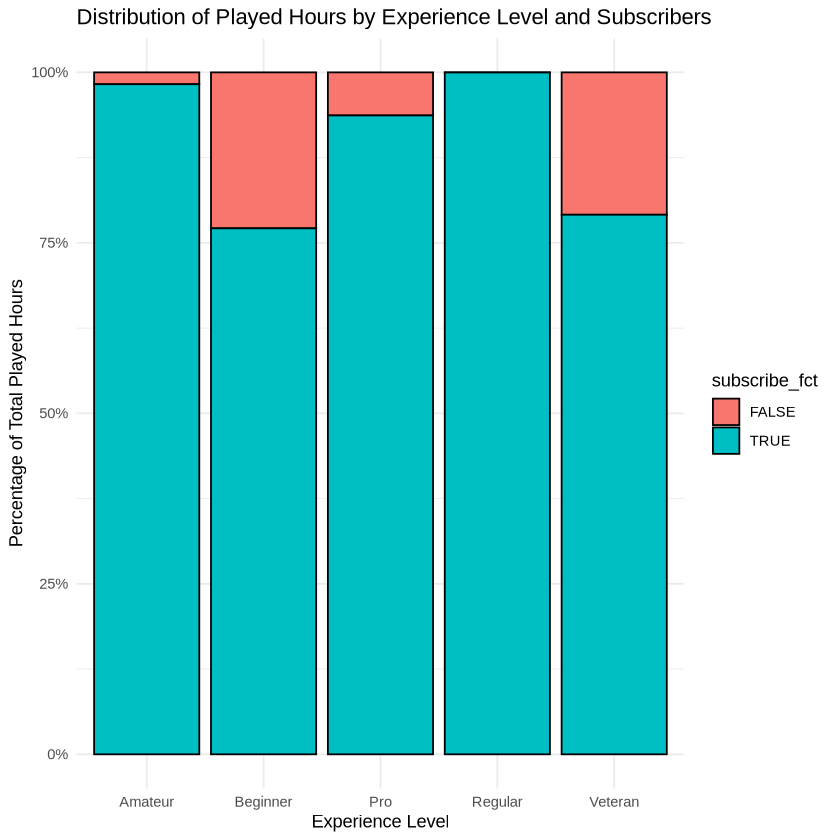

In [8]:
plot_data <- players_tidy |>
  group_by(experience, subscribe_fct) |>
  summarise(total_hours = sum(played_hours), .groups = "drop") |> group_by(experience) |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct <- ggplot(plot_data,
                                         aes(x = experience,
                                             y = percentage,fill=subscribe_fct)) +
  geom_bar(stat = "identity", position = "fill", colour="black") +
  scale_y_continuous(labels = percent_format()) +
  labs(
    x = "Experience Level",
    y = "Percentage of Total Played Hours",
    title = "Distribution of Played Hours by Experience Level and Subscribers"
  ) +
  theme_minimal()

experience_gender_percent_plot_fct

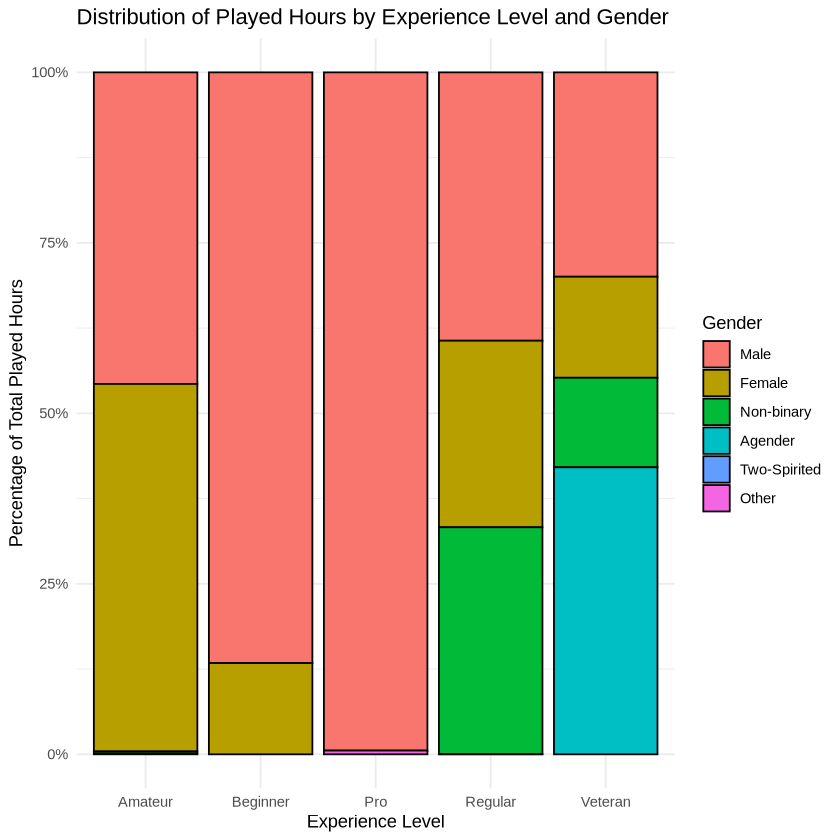

In [9]:
plot_data <- players_tidy |>
  group_by(experience, gender_fct) |>
  summarise(total_hours = sum(played_hours), .groups = "drop") |>
  group_by(experience) |>
  mutate(percentage = total_hours / sum(total_hours))

experience_gender_percent_plot_fct<- ggplot(plot_data,
                                         aes(x = experience,
                                             y = percentage,
                                             fill = gender_fct)) +
  geom_bar(stat = "identity", position = "fill", colour="black") +
  scale_y_continuous(labels = percent_format()) +
  labs(
    x = "Experience Level",
    y = "Percentage of Total Played Hours",
    fill = "Gender",
    title = "Distribution of Played Hours by Experience Level and Gender"
  ) +
  theme_minimal()

experience_gender_percent_plot_fct

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


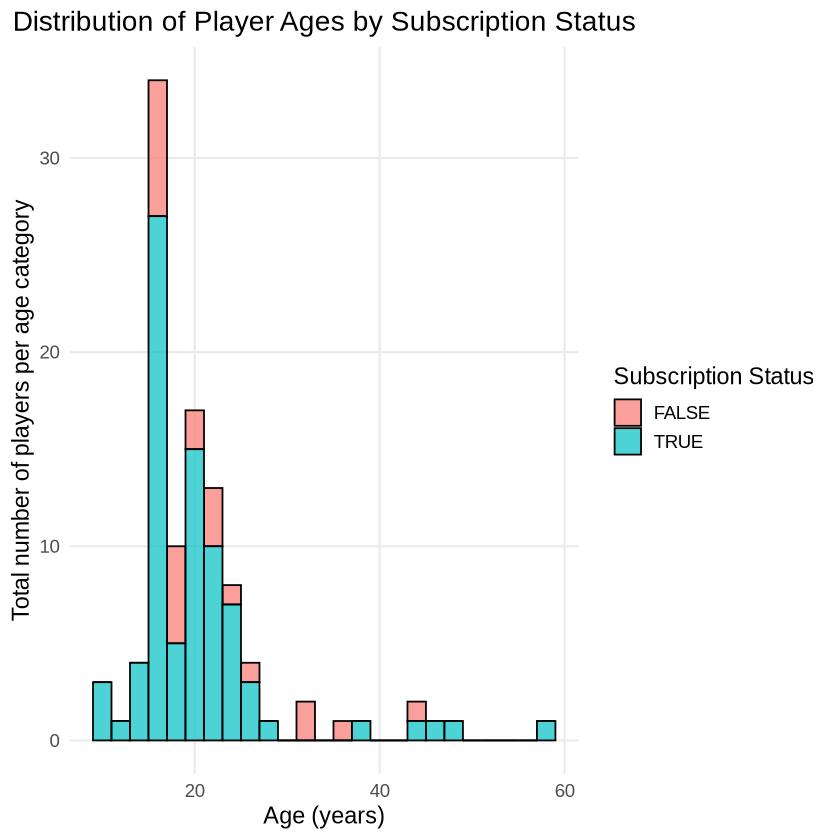

In [10]:
players_age_hours_hist <- players_tidy |> 
   ggplot(aes(x = Age, fill = subscribe_fct)) +
  geom_histogram(binwidth = 2,color="black", alpha=0.7) +
  labs(
    title = "Distribution of Player Ages by Subscription Status",
    x = "Age (years)",
    y = "Total number of players per age category",
    fill = "Subscription Status"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "right",
    panel.grid.minor = element_blank())
  
players_age_hours_hist

experience,total_hours,total_hours_fct
<chr>,<dbl>,<fct>
Amateur,379.1,379.1
Beginner,41.1,41.1
Pro,36.4,36.4
Regular,655.4,655.4
Veteran,29.7,29.7


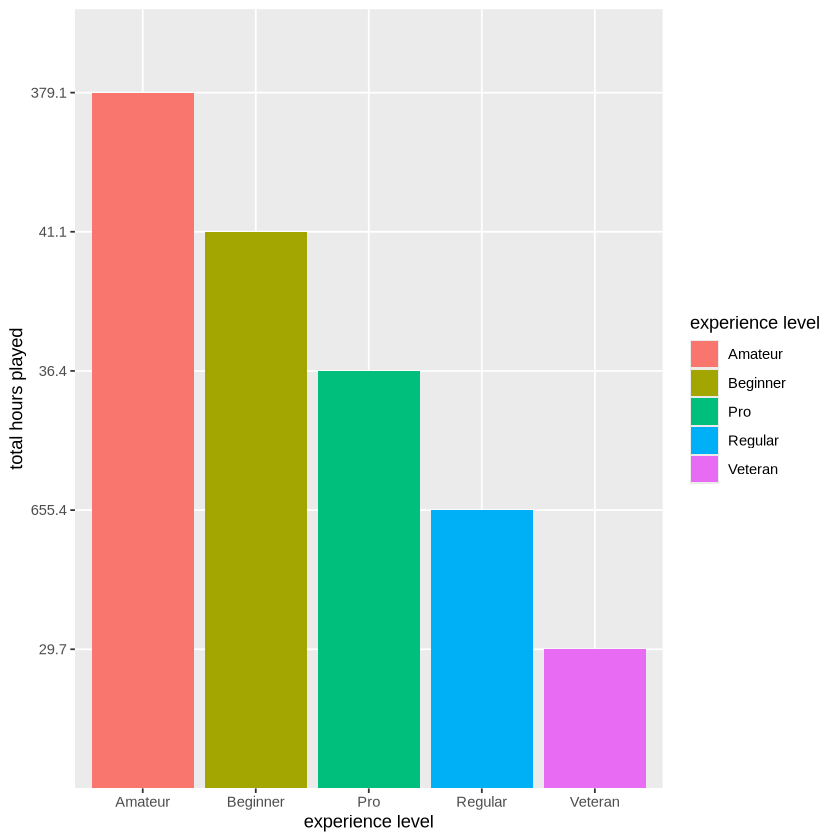

In [11]:
bar_plot_tidy_players<-players_tidy |>
  group_by(experience) |>
  summarise(total_hours = sum(played_hours)) |>   
   mutate(total_hours_fct=as_factor(total_hours)) 
bar_plot_tidy_players


bar_plot_experience_vs_totalhrs<- bar_plot_tidy_players |> 
  ggplot(aes(x = experience, y =fct_reorder(total_hours_fct, experience, .desc=TRUE), fill=experience)) +
  geom_bar(stat = "identity") + labs(x="experience level", y="total hours played", fill="experience level") 
bar_plot_experience_vs_totalhrs